# 1. Introduction

**About DonorsChoose**   

Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

1) How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible

2) How to increase the consistency of project vetting across different volunteers to improve the experience for teachers

3) How to focus volunteer time on the applications that need the most assistance

**Competition Goal**  

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

**This Notebook Goal**

The first goal is to do a comprehensive EDA. Next, I will be doing Feature Engineering in order to build a set of robust Machine Learning algorithms.

# 2. Importing Libraries and Data

## 2.1 Load libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()
import plotly.tools as tls
import squarify
from mpl_toolkits.basemap import Basemap
from numpy import array
from matplotlib import cm

# Get rid of annoying warnings 
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm, skew



from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import TextBlob
import datetime as dt
import warnings
import string
import time

stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

## 2.2 Load Data

In [2]:
train = pd.read_csv("train-3.csv")
test = pd.read_csv("test-3.csv")
resources = pd.read_csv("resources.csv")

## Merging resources data with train and test data ##
train_resource = pd.merge(train, resources, on="id", how='left')
test_resource = pd.merge(test, resources, on="id", how='left')

In [3]:
print("Size of training data : ",train.shape)
print("Size of test data : ",test.shape)
print("Size of resource data : ",resources.shape)
print("Size of train_resource data : ",train_resource.shape)
print("Size of test_resource data : ",test_resource.shape)

Size of training data :  (182080, 16)
Size of test data :  (78035, 15)
Size of resource data :  (1541272, 4)
Size of train_resource data :  (1081830, 19)
Size of test_resource data :  (459442, 18)


# 3. Looking at Data

## 3.1 Tables

**train table**

In [4]:
train.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2017-04-26 15:57:28             Grades 3-5   
2        2017-01-01 22:57:44             Grades 3-5   
3        2016-08-12 15:42:11             Grades 3-5   
4        2016-08-06 09:09:11             Grades 6-8   

            project_subject_categories  \
0                  Literacy & Language   
1    Music & The Arts, Health & Sports   
2  Math & Science, Literacy & Language   
3                      Health & Sports   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1            Performing Arts, Team Sports   
2  Applied Sciences, Literature & Writing   
3                       Health & Wellness   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                             Keep Calm and Dance On   
2                              Lets 3Doodle to Learn   
3  \"Kid Inspired\" Equipment to Increase Activit...   
4   We need clean water for our culinary arts class!   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Our elementary school is a culturally rich sch...   
2  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
3  My students are the greatest students but are ...   
4  My students are athletes and students who are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  We strive to provide our diverse population of...             NaN   
2  We are looking to add some 3Doodler to our cla...             NaN   
3  The student's project which is totally \"kid-i...             NaN   
4  For some reason in our kitchen the water comes...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need matching shirts to wear for d...   
2             NaN  My students need the 3doodler. We are an SEM s...   
3             NaN  My students need balls and other activity equi...   
4             NaN  My students need a water filtration system for...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                            26                    1  
1                                             1                    0  
2                                             5                    1  
3                                            16                    0  
4                                            42                    1

**test table**

In [5]:
test.head()

id                        teacher_id teacher_prefix school_state  \
0  p233245  5724a0c3ce11008366fff36dab4b943c            Ms.           CA   
1  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
2  p236235  e92a4902b1611a189643d6f12c51e6a0           Mrs.           SC   
3  p233680  8e92622d2985d3faac1de71609c4be72           Mrs.           IA   
4  p171879  91a3c89981f626d9a0d067c65fb186ce            Mr.           CA   

  project_submitted_datetime project_grade_category  \
0        2016-04-27 13:45:41          Grades PreK-2   
1        2016-04-28 12:43:56             Grades 3-5   
2        2016-04-29 21:16:05          Grades PreK-2   
3        2016-04-27 22:32:43          Grades PreK-2   
4        2016-04-27 18:59:15             Grades 6-8   

            project_subject_categories      project_subject_subcategories  \
0                     Music & The Arts                        Visual Arts   
1  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
2                       Math & Science      Applied Sciences, Mathematics   
3                  Literacy & Language                           Literacy   
4      Music & The Arts, Special Needs     Performing Arts, Special Needs   

                         project_title  \
0             Art Will Make You Happy!   
1            Keeping up with the TIMEs   
2  Building Bridges to Problem Solving   
3                    Classroom Library   
4                 Reeds so we can Read   

                                     project_essay_1  \
0  My 2nd grade students are amazing!  They are v...   
1  Students within the classroom work in small gr...   
2  My students share  a love of learning. These s...   
3  Reading is the gateway to the soul.  Guiding c...   
4  \"Mr. Reyes!  I need another reed!\"  I hear t...   

                                     project_essay_2  \
0  My class is made up of 12 boys and 12 girls.  ...   
1  My students are all very talented young indivi...   
2  My class consists of 14 energetic learners.  O...   
3  First graders enter the classroom each day rea...   
4  We have a diverse population with almost entir...   

                                     project_essay_3  \
0  My second grade class will really benefit from...   
1  We do a lot of small group, where the student ...   
2  These Fairy Tale Problem Solving STEM kits wil...   
3  Book bins will help to organize our classroom ...   
4  Each day in my class students consume supplies...   

                                     project_essay_4  \
0  The genorous donations to my project will make...   
1  This project is very important to my classroom...   
2  These materials will be help my students with ...   
3  When students begin the first grade, many are ...   
4  My students come from very troubled homes and ...   

                            project_resource_summary  \
0  My students need a drying rack for their art p...   
1  My students need Time Magazines for next year ...   
2  My students need to be mentally stimulated to ...   
3   My students need an organized classroom library.   
4  My students need reeds to perform in class eac...   

   teacher_number_of_previously_posted_projects  
0                                             2  
1                                             1  
2                                             0  
3                                             0  
4                                             1

**resources table**

In [6]:
resources.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

**train_resource table**

In [7]:
train_resource.head()

id                        teacher_id teacher_prefix school_state  \
0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
1  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
2  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
3  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
4  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   

  project_submitted_datetime project_grade_category  \
0        2016-11-18 14:45:59          Grades PreK-2   
1        2016-11-18 14:45:59          Grades PreK-2   
2        2017-04-26 15:57:28             Grades 3-5   
3        2017-01-01 22:57:44             Grades 3-5   
4        2016-08-12 15:42:11             Grades 3-5   

            project_subject_categories  \
0                  Literacy & Language   
1                  Literacy & Language   
2    Music & The Arts, Health & Sports   
3  Math & Science, Literacy & Language   
4                      Health & Sports   

            project_subject_subcategories  \
0                                Literacy   
1                                Literacy   
2            Performing Arts, Team Sports   
3  Applied Sciences, Literature & Writing   
4                       Health & Wellness   

                                       project_title  \
0                           Super Sight Word Centers   
1                           Super Sight Word Centers   
2                             Keep Calm and Dance On   
3                              Lets 3Doodle to Learn   
4  \"Kid Inspired\" Equipment to Increase Activit...   

                                     project_essay_1  \
0  Most of my kindergarten students come from low...   
1  Most of my kindergarten students come from low...   
2  Our elementary school is a culturally rich sch...   
3  Hello;\r\nMy name is Mrs. Brotherton. I teach ...   
4  My students are the greatest students but are ...   

                                     project_essay_2 project_essay_3  \
0  I currently have a differentiated sight word c...             NaN   
1  I currently have a differentiated sight word c...             NaN   
2  We strive to provide our diverse population of...             NaN   
3  We are looking to add some 3Doodler to our cla...             NaN   
4  The student's project which is totally \"kid-i...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need 6 Ipod Nano's to create and d...   
1             NaN  My students need 6 Ipod Nano's to create and d...   
2             NaN  My students need matching shirts to wear for d...   
3             NaN  My students need the 3doodler. We are an SEM s...   
4             NaN  My students need balls and other activity equi...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            26                    1   
1                                            26                    1   
2                                             1                    0   
3                                             5                    1   
4                                            16                    0   

                                         description  quantity   price  
0  Apple - iPod nano� 16GB MP3 Player (8th Genera...         3  149.99  
1  Apple - iPod nano� 16GB MP3 Player (8th Genera...         3  149.99  
2  Reebok Girls' Fashion Dance Graphic T-Shirt - ...        20   20.00  
3                     3doodler Start Full Edu Bundle         1  469.99  
4                   BALL PG 4'' POLY SET OF 6 COLORS         1   18.95

**test_resource**

In [8]:
test_resource.head()

id                        teacher_id teacher_prefix school_state  \
0  p233245  5724a0c3ce11008366fff36dab4b943c            Ms.           CA   
1  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
2  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
3  p096795  445619941dc7cbe81c7be109dc61a56a           Mrs.           SC   
4  p236235  e92a4902b1611a189643d6f12c51e6a0           Mrs.           SC   

  project_submitted_datetime project_grade_category  \
0        2016-04-27 13:45:41          Grades PreK-2   
1        2016-04-28 12:43:56             Grades 3-5   
2        2016-04-28 12:43:56             Grades 3-5   
3        2016-04-28 12:43:56             Grades 3-5   
4        2016-04-29 21:16:05          Grades PreK-2   

            project_subject_categories      project_subject_subcategories  \
0                     Music & The Arts                        Visual Arts   
1  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
2  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
3  Literacy & Language, Math & Science  Literature & Writing, Mathematics   
4                       Math & Science      Applied Sciences, Mathematics   

                         project_title  \
0             Art Will Make You Happy!   
1            Keeping up with the TIMEs   
2            Keeping up with the TIMEs   
3            Keeping up with the TIMEs   
4  Building Bridges to Problem Solving   

                                     project_essay_1  \
0  My 2nd grade students are amazing!  They are v...   
1  Students within the classroom work in small gr...   
2  Students within the classroom work in small gr...   
3  Students within the classroom work in small gr...   
4  My students share  a love of learning. These s...   

                                     project_essay_2  \
0  My class is made up of 12 boys and 12 girls.  ...   
1  My students are all very talented young indivi...   
2  My students are all very talented young indivi...   
3  My students are all very talented young indivi...   
4  My class consists of 14 energetic learners.  O...   

                                     project_essay_3  \
0  My second grade class will really benefit from...   
1  We do a lot of small group, where the student ...   
2  We do a lot of small group, where the student ...   
3  We do a lot of small group, where the student ...   
4  These Fairy Tale Problem Solving STEM kits wil...   

                                     project_essay_4  \
0  The genorous donations to my project will make...   
1  This project is very important to my classroom...   
2  This project is very important to my classroom...   
3  This project is very important to my classroom...   
4  These materials will be help my students with ...   

                            project_resource_summary  \
0  My students need a drying rack for their art p...   
1  My students need Time Magazines for next year ...   
2  My students need Time Magazines for next year ...   
3  My students need Time Magazines for next year ...   
4  My students need to be mentally stimulated to ...   

   teacher_number_of_previously_posted_projects  \
0                                             2   
1                                             1   
2                                             1   
3                                             1   
4                                             0   

                                         description  quantity   price  
0  LC652 - Lakeshore Double-Space Mobile Drying Rack         1  149.00  
1  Brewster WPD90218 Wall Pops Flirt Dot, Set of ...         2    9.95  
2  Brewster Wall Pops WPE99065 Peel & Stick Calyp...         2    9.02  
3  TIME For Kids - 3-4 PRINT Bundle - 24 issues /...        40    5.01  
4     PP440X - Fairy Tales Problem Solving STEM Kits         2  149.00

## 3.2 Statistical Information of Data

**train table**


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [10]:
train.describe()

teacher_number_of_previously_posted_projects  project_is_approved
count                                 182080.000000        182080.000000
mean                                      11.237055             0.847682
std                                       28.016086             0.359330
min                                        0.000000             0.000000
25%                                        0.000000             1.000000
50%                                        2.000000             1.000000
75%                                        9.000000             1.000000
max                                      451.000000             1.000000

**train table categorical features**

In [11]:
train.describe(include=['O'])

id                        teacher_id teacher_prefix school_state  \
count    182080                            182080         182076       182080   
unique   182080                            104414              5           51   
top     p007005  fa2f220b537e8653fb48878ebb38044d           Mrs.           CA   
freq          1                                74          95405        25695   

       project_submitted_datetime project_grade_category  \
count                      182080                 182080   
unique                     180439                      4   
top           2016-09-01 00:00:03          Grades PreK-2   
freq                           30                  73890   

       project_subject_categories project_subject_subcategories  \
count                      182080                        182080   
unique                         51                           407   
top           Literacy & Language                      Literacy   
freq                        39257                         15775   

           project_title                                    project_essay_1  \
count             182080                                             182080   
unique            164282                                             147689   
top     Flexible Seating  As a teacher in a low-income/high poverty scho...   
freq                 377                                                 46   

                                          project_essay_2  \
count                                              182080   
unique                                             180984   
top     Students will be using Chromebooks to increase...   
freq                                                   24   

                                          project_essay_3  \
count                                                6374   
unique                                               6359   
top     The books I am requesting are exciting because...   
freq                                                    2   

                                          project_essay_4  \
count                                                6374   
unique                                               6336   
top     As a teacher, it is important to show students...   
freq                                                    3   

                                 project_resource_summary  
count                                              182080  
unique                                             179730  
top     My students need electronic tablets to do all ...  
freq                                                   84

**train-resource table**

In [12]:
train_resource.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081830 entries, 0 to 1081829
Data columns (total 19 columns):
id                                              1081830 non-null object
teacher_id                                      1081830 non-null object
teacher_prefix                                  1081819 non-null object
school_state                                    1081830 non-null object
project_submitted_datetime                      1081830 non-null object
project_grade_category                          1081830 non-null object
project_subject_categories                      1081830 non-null object
project_subject_subcategories                   1081830 non-null object
project_title                                   1081830 non-null object
project_essay_1                                 1081830 non-null object
project_essay_2                                 1081830 non-null object
project_essay_3                                 38157 non-null object
project_essay_4          

In [13]:
train_resource.describe()

teacher_number_of_previously_posted_projects  project_is_approved  \
count                                  1.081830e+06         1.081830e+06   
mean                                   1.254963e+01         7.923777e-01   
std                                    3.038872e+01         4.056050e-01   
min                                    0.000000e+00         0.000000e+00   
25%                                    0.000000e+00         1.000000e+00   
50%                                    3.000000e+00         1.000000e+00   
75%                                    1.000000e+01         1.000000e+00   
max                                    4.510000e+02         1.000000e+00   

           quantity         price  
count  1.081830e+06  1.081830e+06  
mean   2.856420e+00  5.011038e+01  
std    7.529482e+00  1.431715e+02  
min    1.000000e+00  0.000000e+00  
25%    1.000000e+00  7.870000e+00  
50%    1.000000e+00  1.499000e+01  
75%    2.000000e+00  3.964000e+01  
max    8.000000e+02  9.999000e+03

In [14]:
train_resource.describe(include=['O'])

id                        teacher_id teacher_prefix school_state  \
count   1081830                           1081830        1081819      1081830   
unique   182080                            104414              5           51   
top     p009778  062339e2c5ca3b602351bb02ffef9ae4           Mrs.           CA   
freq        100                               739         546894       154076   

       project_submitted_datetime project_grade_category  \
count                     1081830                1081830   
unique                     180439                      4   
top           2016-09-01 00:00:03          Grades PreK-2   
freq                          347                 460457   

       project_subject_categories project_subject_subcategories  \
count                     1081830                       1081830   
unique                         51                           407   
top           Literacy & Language                      Literacy   
freq                       317477                        142889   

           project_title                                    project_essay_1  \
count            1081830                                            1081830   
unique            164282                                             147689   
top     Flexible Seating  Nestled in the heart of the South Bronx is an ...   
freq                1542                                                421   

                                          project_essay_2  \
count                                             1081830   
unique                                             180984   
top     Many of our students live in shelters and fost...   
freq                                                  173   

                                          project_essay_3  \
count                                               38157   
unique                                               6359   
top     My students will use the blocks to build tall ...   
freq                                                   94   

                                          project_essay_4  \
count                                               38157   
unique                                               6336   
top     According to the NAEYC, children who grow up i...   
freq                                                   94   

                                 project_resource_summary  \
count                                             1081830   
unique                                             179730   
top     My students need electronic tablets to do all ...   
freq                                                  171   

                                              description  
count                                             1081638  
unique                                             269995  
top     Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...  
freq                                                 2171

**test table**

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78035 entries, 0 to 78034
Data columns (total 15 columns):
id                                              78035 non-null object
teacher_id                                      78035 non-null object
teacher_prefix                                  78034 non-null object
school_state                                    78035 non-null object
project_submitted_datetime                      78035 non-null object
project_grade_category                          78035 non-null object
project_subject_categories                      78035 non-null object
project_subject_subcategories                   78035 non-null object
project_title                                   78035 non-null object
project_essay_1                                 78035 non-null object
project_essay_2                                 78035 non-null object
project_essay_3                                 2704 non-null object
project_essay_4                                 2704

In [16]:
test.describe()

teacher_number_of_previously_posted_projects
count                                  78035.000000
mean                                      11.275082
std                                       27.981717
min                                        0.000000
25%                                        0.000000
50%                                        2.000000
75%                                        9.000000
max                                      448.000000

In [17]:
test.describe(include=['O'])

id                        teacher_id teacher_prefix school_state  \
count     78035                             78035          78034        78035   
unique    78035                             55508              5           51   
top     p080058  df8a4b7ad173b57f7ac52e447cc24043           Mrs.           CA   
freq          1                                37          40982        10723   

       project_submitted_datetime project_grade_category  \
count                       78035                  78035   
unique                      77646                      4   
top           2016-09-01 00:00:08          Grades PreK-2   
freq                            8                  31471   

       project_subject_categories project_subject_subcategories  \
count                       78035                         78035   
unique                         51                           390   
top           Literacy & Language                      Literacy   
freq                        16777                          6859   

           project_title                                    project_essay_1  \
count              78035                                              78035   
unique             72755                                              69435   
top     Flexible Seating  I teach a special day class that is filled wit...   
freq                 167                                                 23   

                                          project_essay_2  \
count                                               78035   
unique                                              77826   
top     Students will be using Chromebooks to increase...   
freq                                                   11   

                                          project_essay_3  \
count                                                2704   
unique                                               2702   
top     These materials would will protect the eyes of...   
freq                                                    2   

                                          project_essay_4  \
count                                                2704   
unique                                               2692   
top     Currently, there is a huge problem with inner-...   
freq                                                    3   

                                 project_resource_summary  
count                                               78035  
unique                                              77531  
top     My students need electronic tablets to do all ...  
freq                                                   32

**test_resource table**

In [18]:
test_resource.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459442 entries, 0 to 459441
Data columns (total 18 columns):
id                                              459442 non-null object
teacher_id                                      459442 non-null object
teacher_prefix                                  459441 non-null object
school_state                                    459442 non-null object
project_submitted_datetime                      459442 non-null object
project_grade_category                          459442 non-null object
project_subject_categories                      459442 non-null object
project_subject_subcategories                   459442 non-null object
project_title                                   459442 non-null object
project_essay_1                                 459442 non-null object
project_essay_2                                 459442 non-null object
project_essay_3                                 16633 non-null object
project_essay_4                       

In [19]:
test_resource.describe()

teacher_number_of_previously_posted_projects       quantity  \
count                                 459442.000000  459442.000000   
mean                                      12.724873       2.870138   
std                                       30.623069       7.665703   
min                                        0.000000       1.000000   
25%                                        0.000000       1.000000   
50%                                        3.000000       1.000000   
75%                                       10.000000       2.000000   
max                                      448.000000     601.000000   

               price  
count  459442.000000  
mean       50.692728  
std       148.342965  
min         0.000000  
25%         7.940000  
50%        14.990000  
75%        39.950000  
max      9999.000000

In [20]:
test_resource.describe(include=['O'])

id                        teacher_id teacher_prefix school_state  \
count    459442                            459442         459441       459442   
unique    78035                             55508              5           51   
top     p137603  ce3aca1472e766884016750d44211c5c           Mrs.           CA   
freq        100                               346         236320        65445   

       project_submitted_datetime project_grade_category  \
count                      459442                 459442   
unique                      77646                      4   
top           2017-01-21 14:13:17          Grades PreK-2   
freq                          100                 195880   

       project_subject_categories project_subject_subcategories  \
count                      459442                        459442   
unique                         51                           390   
top           Literacy & Language                      Literacy   
freq                       135093                         63645   

           project_title                                    project_essay_1  \
count             459442                                             459442   
unique             72755                                              69435   
top     Flexible Seating  My students love to learn. Their loving famili...   
freq                 687                                                318   

                                          project_essay_2  \
count                                              459442   
unique                                              77826   
top     I have chosen highly sought after books that w...   
freq                                                  100   

                                          project_essay_3  \
count                                               16633   
unique                                               2702   
top     These nonfiction books will provide my student...   
freq                                                   77   

                                          project_essay_4  \
count                                               16633   
unique                                               2692   
top     These books will provide a way for my students...   
freq                                                   77   

                                 project_resource_summary  \
count                                              459442   
unique                                              77531   
top     My students need inspirational, imaginative, i...   
freq                                                  100   

                                              description  
count                                              459342  
unique                                             157742  
top     Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...  
freq                                                  866

## 3.3 Dealing with Missing Data

**train table**

In [21]:
# checking for missing data in train table 
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train.head()

Total    Percent
project_essay_4                               175706  96.499341
project_essay_3                               175706  96.499341
teacher_prefix                                     4   0.002197
project_is_approved                                0   0.000000
teacher_number_of_previously_posted_projects       0   0.000000

More than 96% missing data in project_essay_3 and project_essay_4! It is better to remove these two columns when predicting.

**test table**

In [22]:
# checking for missing data in test table 
total = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending = False)
missing_test  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test.head()

Total    Percent
project_essay_4                               75331  96.534888
project_essay_3                               75331  96.534888
teacher_prefix                                    1   0.001281
teacher_number_of_previously_posted_projects      0   0.000000
project_resource_summary                          0   0.000000

Again more than 96% missing data in project_essay_3 and project_essay_4! It is better to remove these two columns when predicting.

**resources table**

In [23]:
# checking for missing data in resources table 
total = resources.isnull().sum().sort_values(ascending = False)
percent = (resources.isnull().sum()/resources.isnull().count()*100).sort_values(ascending = False)
missing_resources  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_resources.head()

Total   Percent
description    292  0.018945
price            0  0.000000
quantity         0  0.000000
id               0  0.000000

Very few missing data only in description column. So we can just ignore those.

# 4. Exploratory Data Analysis

## 4.1 Project Approval

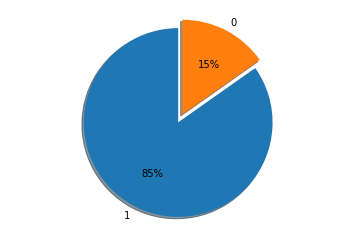

In [24]:
temp = train['project_is_approved'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100 
explode = (.1,0)  # only "explode" the 1st slice (i.e. 'approved')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

As you can see train data is highly imbalanced. 85% approved versus 15% rejected.

## 4.2 School Distribution in Different States

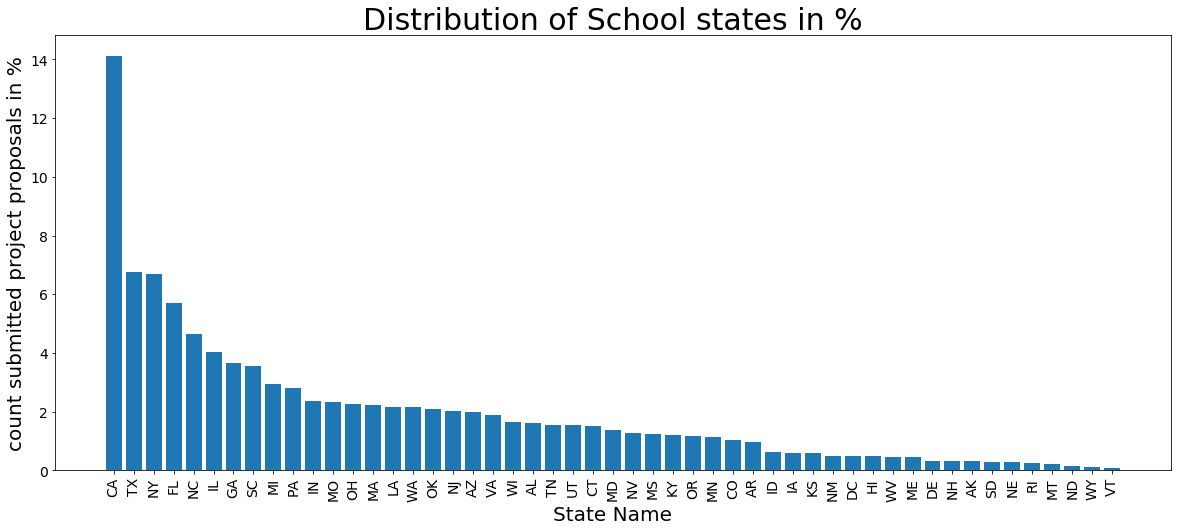

In [25]:
state = train["school_state"].value_counts()
state_percentage=(state / state.sum())*100
x=state.index
fig2, ax2 = plt.subplots(figsize=(20,8))
ax2.bar(x,state_percentage)
plt.title('Distribution of School states in %',size=30)
plt.xlabel('State Name' ,size=20)
plt.ylabel('count submitted project proposals in %',size=20)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.show()


California(CA) with 14% has the highest number of projects proposal submitted followed by Texas(TX)(7 %) and New York(NY)(7 %).

## 4.3 Project Grade Category Distribution

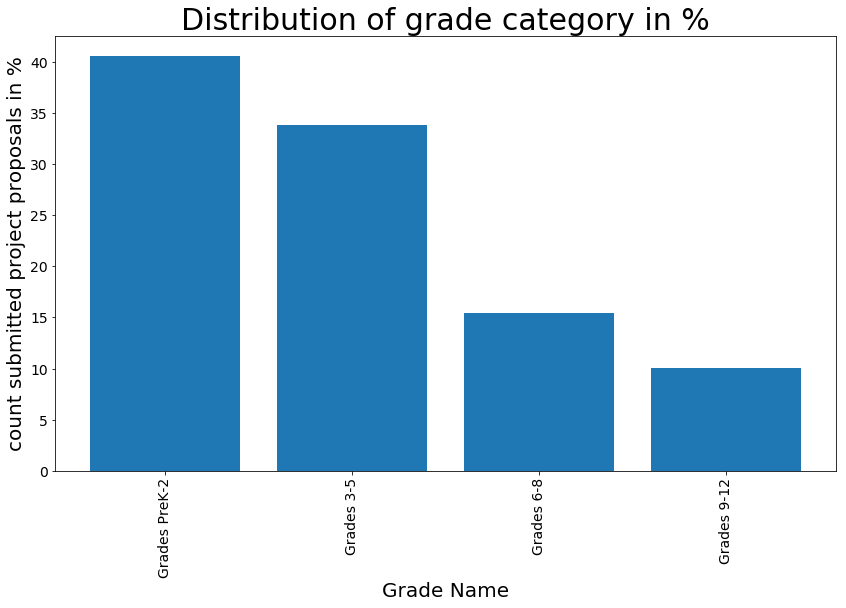

In [26]:
pgc = train["project_grade_category"].value_counts()
pgc_percentage=(pgc / pgc.sum())*100
x=pgc.index
fig3, ax3 = plt.subplots(figsize=(14,8))
ax3.bar(x,pgc_percentage)
plt.title('Distribution of grade category in %',size=30)
plt.xlabel('Grade Name' ,size=20)
plt.ylabel('count submitted project proposals in %',size=20)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.show()

Grades preK-2 with more than 40% has the highest submitted project proposals.

## 4.4 Distribution of Category of Projects

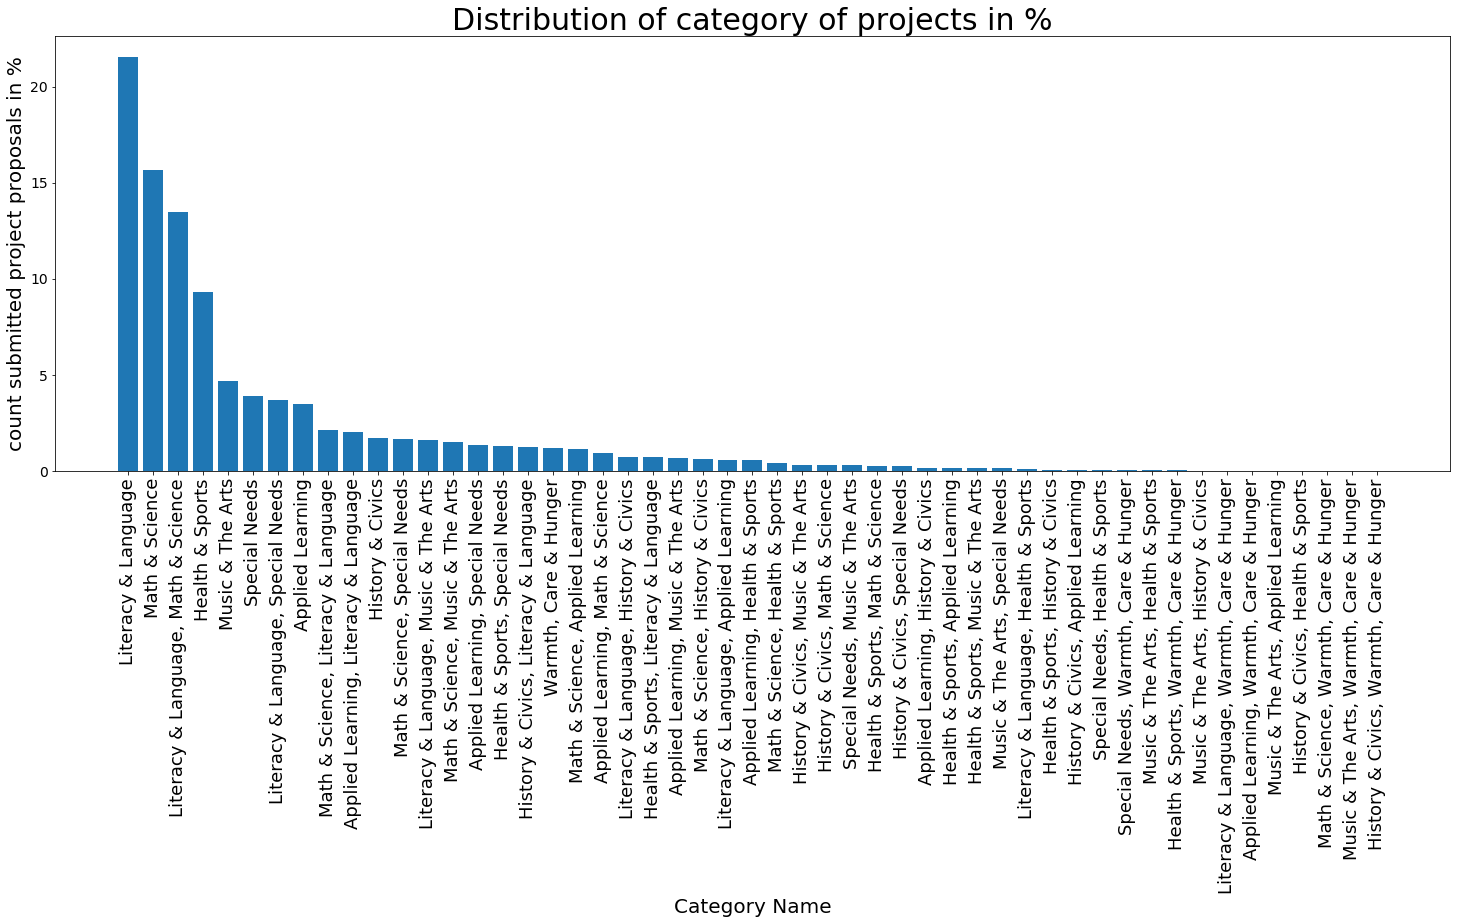

In [27]:
psc = train["project_subject_categories"].value_counts()
psc_percentage=(psc / psc.sum())*100
x=psc.index
fig4, ax4 = plt.subplots(figsize=(25,8))
ax4.bar(x,psc_percentage)
plt.title('Distribution of category of projects in %',size=30)
plt.xlabel('Category Name' ,size=20)
plt.ylabel('count submitted project proposals in %',size=20)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=14)
plt.show()

Out of 51 Project categories, Project proposals submission for project categories is higher for Literacy & Language which is approx. 27 % followed by Math & Science which has approx. 20 %.

## 4.5  Distribution of number of previously posted applications by the submitting teacher


 mu = 11.24 and sigma = 28.02



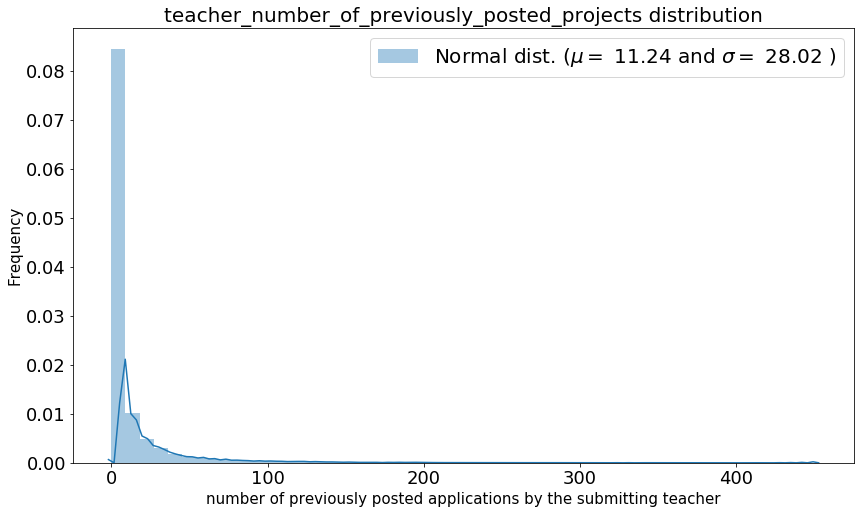

In [28]:
plt.figure(figsize = (14, 8))
(mu, sigma) = norm.fit(train['teacher_number_of_previously_posted_projects'])

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


sns.distplot(train['teacher_number_of_previously_posted_projects'])

plt.title('teacher_number_of_previously_posted_projects distribution',size=20)
plt.xlabel('number of previously posted applications by the submitting teacher', size=15)
plt.ylabel('Frequency',size=15)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show() 

## 4.6 Distribution of subcategory of the project

There are 407 subcategories 

We only show the subcategories with more than 1%


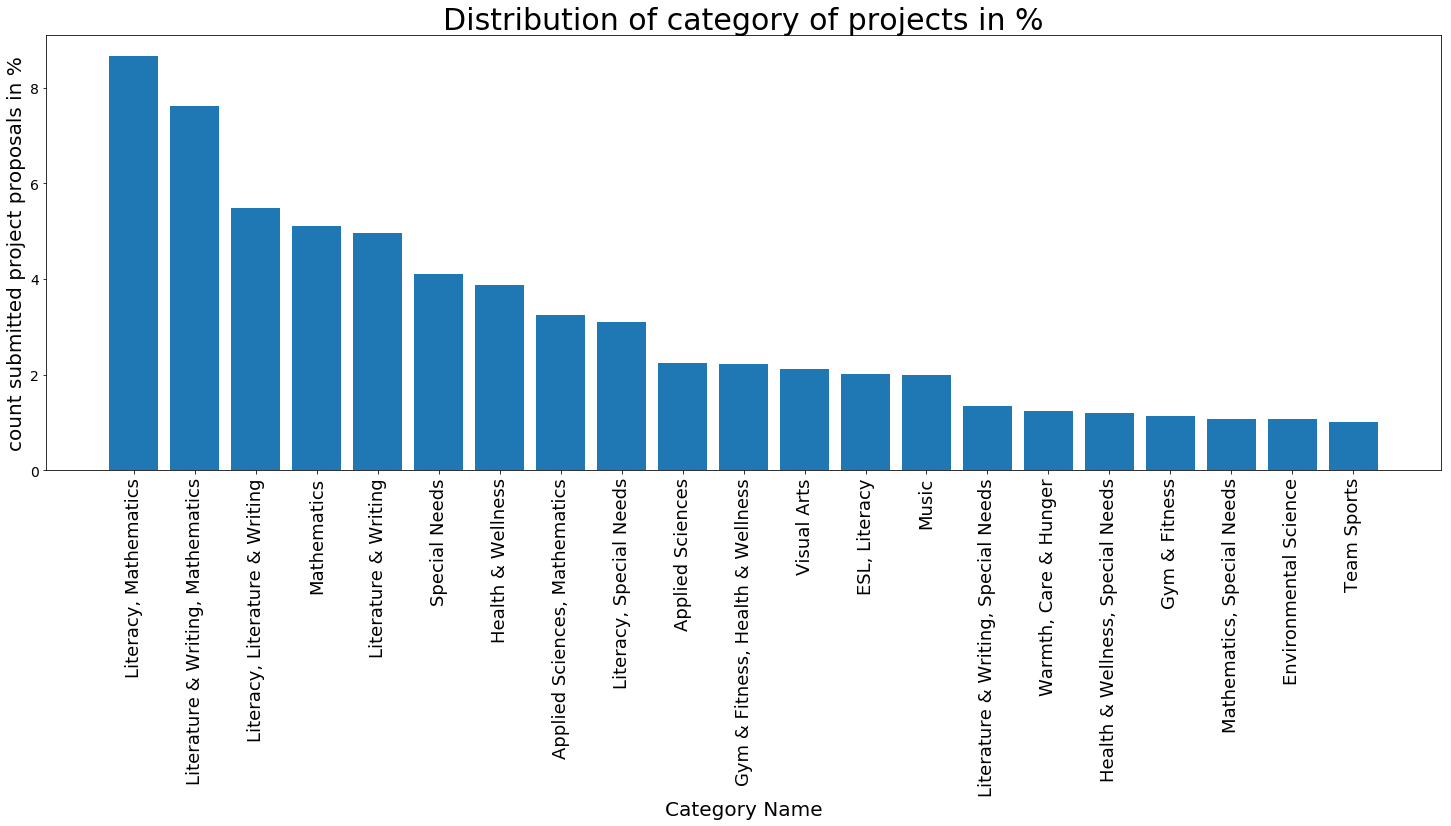

In [29]:
pss = train["project_subject_subcategories"].value_counts()
print('There are {} subcategories \n'.format(len(pss)))
threshold=1
print('We only show the subcategories with more than {}%'.format(threshold))
pss_percentage=(pss / pss.sum())*100
x=pss.index

fig6, ax6 = plt.subplots(figsize=(25,8))
ax6.bar(x[1:len(pss_percentage[pss_percentage>threshold])+1],pss_percentage[pss_percentage>threshold])
plt.title('Distribution of category of projects in %',size=30)
plt.xlabel('Category Name' ,size=20)
plt.ylabel('count submitted project proposals in %',size=20)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=14)
plt.show()

## 4.7  Distribution of Project Titles

There are 164282 titles 



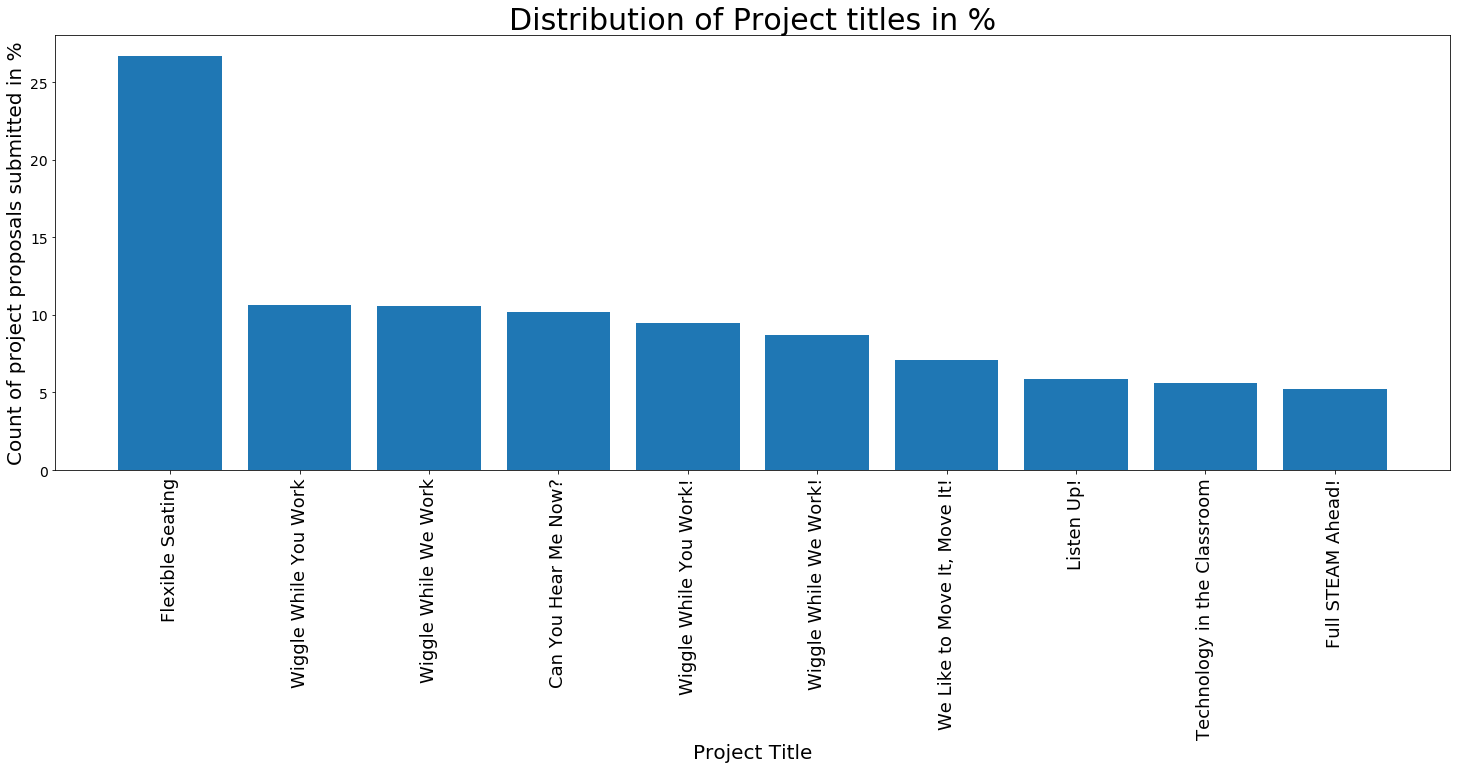

In [30]:
pt = train["project_title"].value_counts().head(10)
print('There are {} titles \n'.format(len(train["project_title"].value_counts())))
pt_percentage=(pt / pt.sum())*100
x=pt.index

fig7, ax7 = plt.subplots(figsize=(25,8))
ax7.bar(x,pt_percentage)
plt.title('Distribution of Project titles in %',size=30)
plt.xlabel('Project Title' ,size=20)
plt.ylabel('Count of project proposals submitted in %',size=20)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=14)
plt.show()

## 4.8 Distribution of Price of Resource Requested


 mu = 50.28 and sigma = 144.73



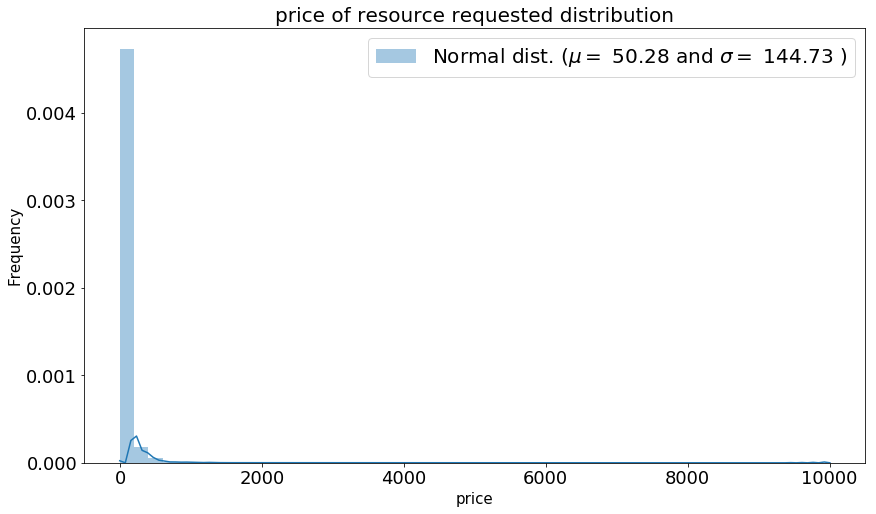

In [31]:
plt.figure(figsize = (14, 8))
(mu, sigma) = norm.fit(resources['price'])

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


sns.distplot(resources['price'])

plt.title('price of resource requested distribution',size=20)
plt.xlabel('price', size=15)
plt.ylabel('Frequency',size=15)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show() 

## 4.9 Distribution of Quantity of Resource Requested


 mu = 2.86 and sigma = 7.57



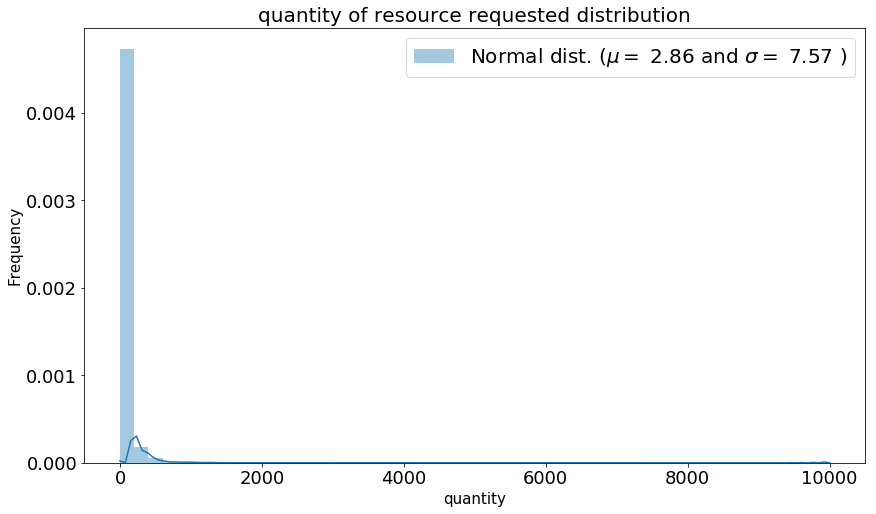

In [32]:
plt.figure(figsize = (14, 8))
(mu, sigma) = norm.fit(resources['quantity'])

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


sns.distplot(resources['price'])

plt.title('quantity of resource requested distribution',size=20)
plt.xlabel('quantity', size=15)
plt.ylabel('Frequency',size=15)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show() 

## 4.10 Distribution of Teacher Prefix 

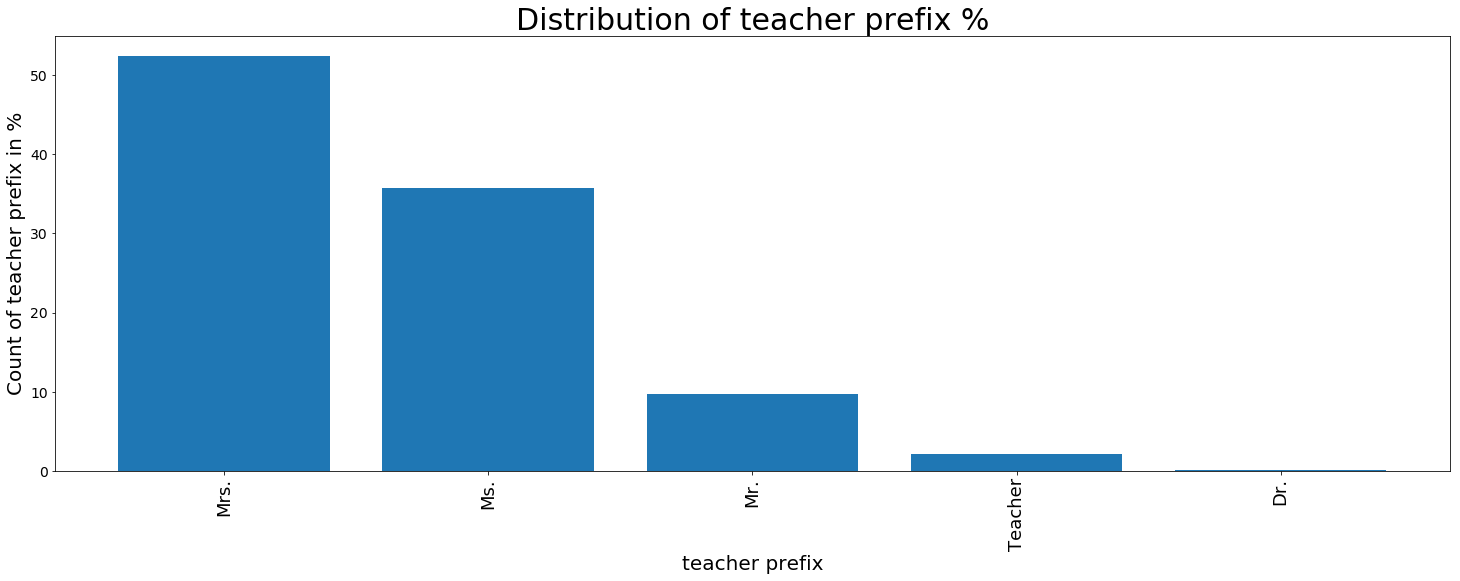

In [33]:
tp = train["teacher_prefix"].value_counts().head(10)
tp_percentage=(tp / tp.sum())*100
x=tp.index

fig8, ax8 = plt.subplots(figsize=(25,8))
ax8.bar(x,tp_percentage)
plt.title('Distribution of teacher prefix %',size=30)
plt.xlabel('teacher prefix' ,size=20)
plt.ylabel('Count of teacher prefix in %',size=20)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=14)
plt.show()

Maried womens submitted project proposals about 53 % of the toal proposals followed by unmarried womens which has approx. 37 %.



## 4.11 Top Resources Needed for the Project

In [34]:
import re
from nltk.corpus import stopwords

space = re.compile('[/(){}\[\]\|@,;]')
unwanted_symbols = re.compile('[^0-9a-z #+_]')
stopwords_set = set(stopwords.words('english'))
def text_preprocess(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = space.sub(' ',text)# replace a set of symbols by space     
    text = unwanted_symbols.sub('',text)# delete symbols which are in unwanted_symbols     
    temp = [s.strip() for s in text.split() if s not in stopwords_set]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

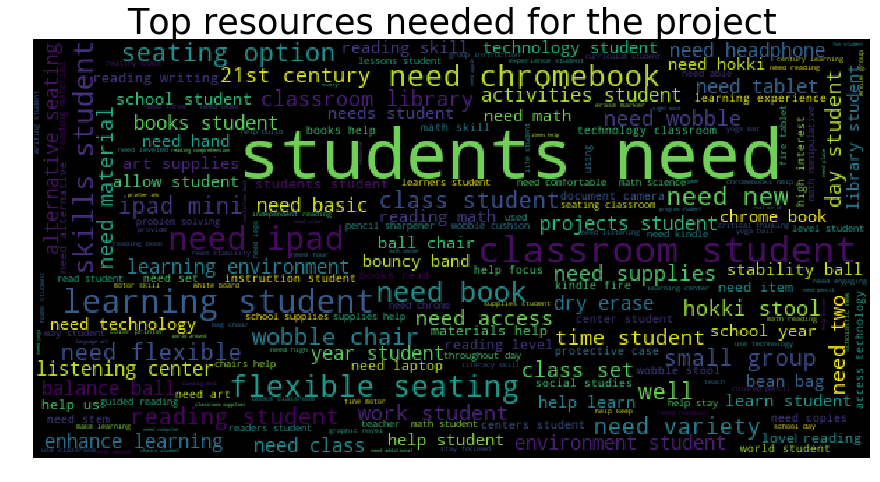

In [35]:
prs_data= train.dropna(subset=['project_resource_summary'])
# converting into lowercase
prs_data['project_resource_summary'] = prs_data['project_resource_summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))
prs_data['project_resource_summary'] = prs_data['project_resource_summary'].map(text_preprocess)

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(prs_data['project_resource_summary'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Top resources needed for the project", fontsize=35)
plt.axis("off")
plt.show() 

## 4.12 Word Cloud of Resources Requested

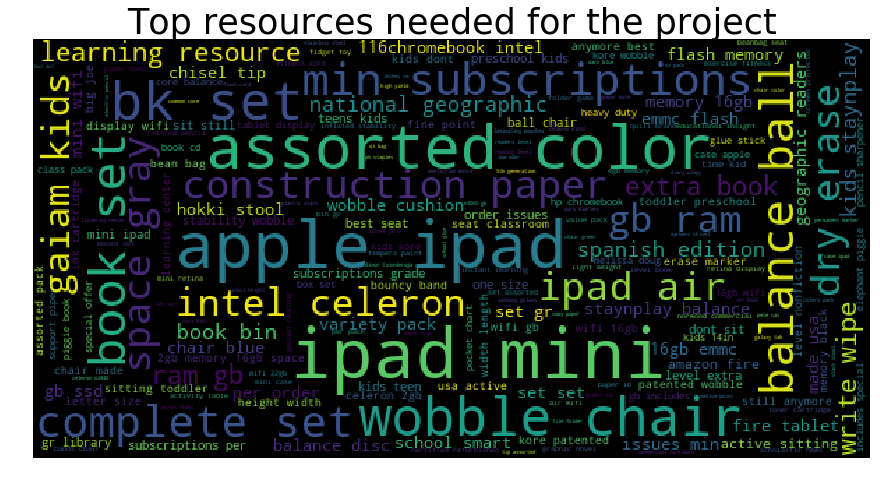

In [36]:
des_data= train_resource.dropna(subset=['description'])
# converting into lowercase
des_data['description'] = des_data['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
des_data['description'] = des_data['description'].map(text_preprocess)

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(des_data['description'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Top resources needed for the project", fontsize=35)
plt.axis("off")
plt.show() 

## 4.13 Project Acceptance Rate and Project Rejection Rate

### 4.13.1 States

In [37]:
school_state = train["school_state"].value_counts()

rejected = []
accepted = []
for val in school_state.index:
    accepted.append(np.sum(train["project_is_approved"][train["school_state"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["school_state"]==val] == 0))    
trace1 = go.Bar(
    x = school_state.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
)
)
trace2 = go.Bar(
    x = school_state.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
)
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Acceptance rate and project rejection rate for different states",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 4.13.2 Teacher Prefix

In [38]:
teacher_prefix = train["teacher_prefix"].value_counts()

rejected = []
accepted = []
for val in teacher_prefix.index:
    accepted.append(np.sum(train["project_is_approved"][train["teacher_prefix"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["teacher_prefix"]==val] == 0))    
trace1 = go.Bar(
    x = teacher_prefix.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
)
)
trace2 = go.Bar(
    x = teacher_prefix.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
)
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Acceptance rate and project rejection rate for different teacher prefix",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 4.13.3 Grade Levels

In [39]:
project_grade_category = train["project_grade_category"].value_counts()

rejected = []
accepted = []
for val in project_grade_category.index:
    accepted.append(np.sum(train["project_is_approved"][train["project_grade_category"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["project_grade_category"]==val] == 0))    
trace1 = go.Bar(
    x = project_grade_category.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
)
)
trace2 = go.Bar(
    x = project_grade_category.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
)
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Acceptance rate and project rejection rate for different school grades",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 4.13.4 Project Category

In [40]:
project_subject_categories = train["project_subject_categories"].value_counts()

rejected = []
accepted = []
for val in project_subject_categories.index:
    accepted.append(np.sum(train["project_is_approved"][train["project_subject_categories"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["project_subject_categories"]==val] == 0))    
trace1 = go.Bar(
    x = project_subject_categories.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
)
)
trace2 = go.Bar(
    x = project_subject_categories.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
)
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Acceptance rate and project rejection rate for different project subject categories",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 4.13.5 Project Subcategory

In [41]:
project_subject_subcategories = train["project_subject_subcategories"].value_counts()

rejected = []
accepted = []
for val in project_subject_subcategories.index:
    accepted.append(np.sum(train["project_is_approved"][train["project_subject_subcategories"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["project_subject_subcategories"]==val] == 0))    
trace1 = go.Bar(
    x = project_subject_subcategories.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
)
)
trace2 = go.Bar(
    x = project_subject_subcategories.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
)
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Acceptance rate and project rejection rate for different project subject subcategories",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 4.14 Project Proposals by US States

In [42]:
school_state = pd.DataFrame(train["school_state"].value_counts()).reset_index()
school_state.columns = ['state_code', 'num_proposals']

data = [dict(
        type='choropleth',
        locations= school_state['state_code'],
        locationmode='USA-states',
        z=school_state['num_proposals'].astype(float),
        text=school_state['state_code'],
        colorscale='Red',
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Number of project proposals'),
)]
layout = dict(title = 'Project Proposals by US States',geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False)

## 4.15 Mean Acceptance of Project Proposals by US States

In [43]:
acceptance_mean = pd.DataFrame(train.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
acceptance_mean.columns = ['state_code', 'num_proposals']

data = [dict(
        type='choropleth',
        locations= acceptance_mean['state_code'],
        locationmode='USA-states',
        z=school_state['num_proposals'].astype(float),
        text=school_state['state_code'],
        colorscale='Red',
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Number of project proposals'),
)]
layout = dict(title = 'Mean acceptance of project proposals by US States',geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False)

## 4.16 Correlation between Teacher_prefix and project_is_approved 

In [ ]:
columns = ['teacher_prefix', 'project_is_approved']
cm = sns.light_palette("red", as_cmap=True)
pd.crosstab(train[columns[0]], train[columns[1]]).style.background_gradient(cmap = cm)

## 4.17 Scatter plot of teacher_number_of_previously_posted_projects and project_is_approved

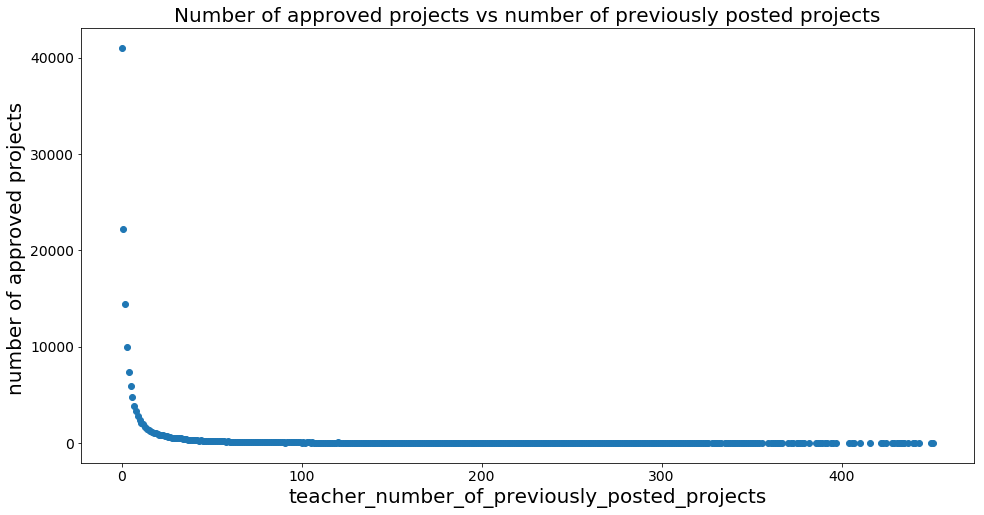

In [44]:
corr = pd.DataFrame(train.groupby("teacher_number_of_previously_posted_projects")["project_is_approved"].apply(np.sum)).reset_index()
corr1=pd.DataFrame(train.groupby("teacher_number_of_previously_posted_projects")["project_is_approved"].apply(lambda x: np.sum(x==0))).reset_index()


result = pd.merge(corr, corr1, on='teacher_number_of_previously_posted_projects')
result.columns=['teacher_number_of_previously_posted_projects','project_is_approved','project_is_not_approved']


fig9, ax9 = plt.subplots(figsize=(16,8))

plt.scatter(result['teacher_number_of_previously_posted_projects'],result['project_is_approved'])

plt.title('Number of approved projects vs number of previously posted projects',size=20)

plt.xlabel('teacher_number_of_previously_posted_projects' ,size=20)
plt.ylabel('number of approved projects ',size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

As seen, number of approved proposals deacreases significantly as number of previously posted projects increases.

## 4.18 Correlation Matrix and Heatmap of training data

In [46]:
numeric_columns=train.select_dtypes(include=[np.number]).columns.tolist() # All numeric columns

In [47]:
corr=train[numeric_columns].corr()
#corr=corr[abs(corr['SalePrice'])>.5] # All correlation above 0.5

## Extracting rows name with correlation above 0.5 
row_index=[]
for index, row in corr.iterrows():
    row_index.append(index)

corr=corr[row_index] 
corr

teacher_number_of_previously_posted_projects  \
teacher_number_of_previously_posted_projects                                      1.000000   
project_is_approved                                                               0.065579   

                                              project_is_approved  
teacher_number_of_previously_posted_projects             0.065579  
project_is_approved                                      1.000000

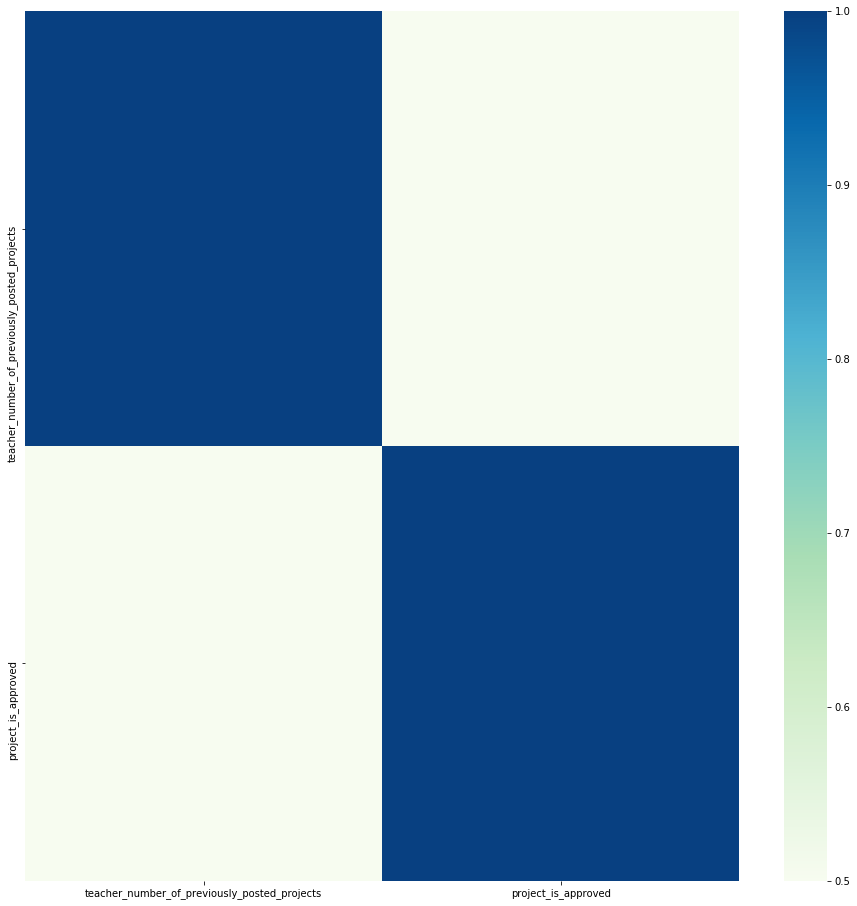

In [48]:
fig10, ax10 = plt.subplots(figsize=(16,16))

sns.heatmap(corr,cmap='GnBu',vmin=.5,vmax=1)
plt.show()

## 4.19 Time Analysis of Project Submission

In [49]:
train["project_submitted_datetime"] = pd.to_datetime(train["project_submitted_datetime"])
train["month_created"] = train["project_submitted_datetime"].dt.month
train["weekday_created"] = train["project_submitted_datetime"].dt.weekday
train["date_created"] = train["project_submitted_datetime"].dt.date
train["hour_created"] = train["project_submitted_datetime"].dt.hour

### 4.19.1 Month Analysis

In [50]:
month_created = train["month_created"].value_counts()

rejected = []
accepted = []
for val in month_created.index:
    accepted.append(np.sum(train["project_is_approved"][train["month_created"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["month_created"]==val] == 0))

month_created.index=["Jan", "Feb", "Mar", "Apr", "May","June","July","Aug","Sep","Oct","Nov","Dec"]
trace1 = go.Bar(
    x = month_created.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
)
)
trace2 = go.Bar(
    x = month_created.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
)
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Month Distribution of Project Proposal Submission",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 4.19.2 Weekday Analysis of Project Submission 

In [51]:
weekday_created = train["weekday_created"].value_counts()

rejected = []
accepted = []
for val in weekday_created.index:
    accepted.append(np.sum(train["project_is_approved"][train["weekday_created"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["weekday_created"]==val] == 0))

weekday_created.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    
    
trace1 = go.Bar(
    x = weekday_created.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
)
)
trace2 = go.Bar(
    x = weekday_created.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
)
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Weekday Distribution of Project Proposal Submission",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 4.19.3 Date Analysis of Project Submission

In [52]:
date_created = train["date_created"].value_counts()

rejected = []
accepted = []
for val in date_created.index:
    accepted.append(np.sum(train["project_is_approved"][train["date_created"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["date_created"]==val] == 0))
    
    
trace1 = go.Bar(
    x = date_created.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
))
trace2 = go.Bar(
    x = date_created.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
))

data = [trace1, trace2]
layout = go.Layout(
    title = "Date Distribution of Project Proposal Submission",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

As seen, there is a spike on a single day (Sep 1, 2016) with respect to the number of proposals. I googled this day and did not find any specific reason or any specific event on this day!

### 4.19.4 Hour Analysis of Project Analysis

In [53]:
hour_created = train["hour_created"].value_counts()

rejected = []
accepted = []
for val in hour_created.index:
    accepted.append(np.sum(train["project_is_approved"][train["hour_created"]==val] == 1))
    rejected.append(np.sum(train["project_is_approved"][train["hour_created"]==val] == 0))
    
    
trace1 = go.Bar(
    x = hour_created.index,
    y = accepted,
    name='Accepted Proposals',
    marker=dict(
        color='blue',
        
))
trace2 = go.Bar(
    x = hour_created.index,
    y = rejected, 
    name='Rejected Proposals',
    marker=dict(
        color='rgb(233, 32, 20)',
        
))

data = [trace1, trace2]
layout = go.Layout(
    title = "Hour Distribution of Project Proposal Submission",
    barmode='stack',
    width = 1000
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 4.20 Top Keywords in project_essay_1

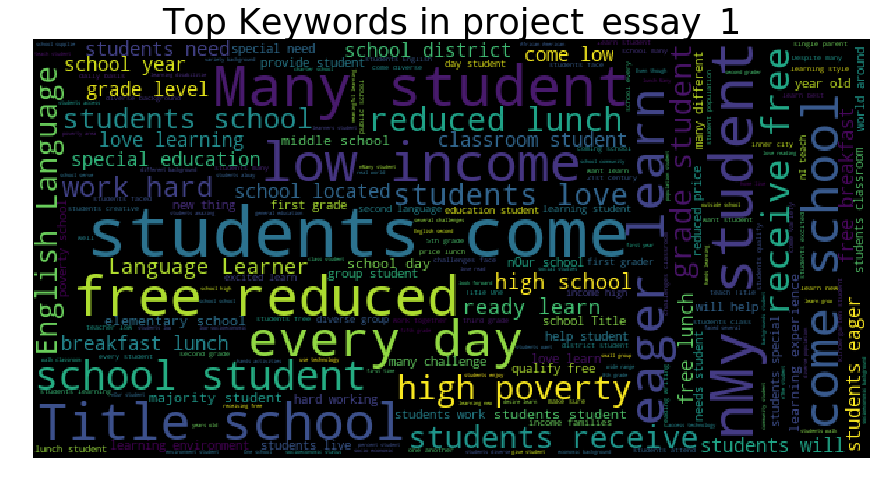

In [54]:
project_essay_1 = train.dropna(subset=['project_essay_1'])
# converting into lowercase
train['project_essay_1'] = train['project_essay_1'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['project_essay_1'] = train['project_essay_1'].map(text_preprocess)


from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(project_essay_1['project_essay_1'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Top Keywords in project_essay_1", fontsize=35)
plt.axis("off")
plt.show()

## 4.21 Top keywords in project_essay_2

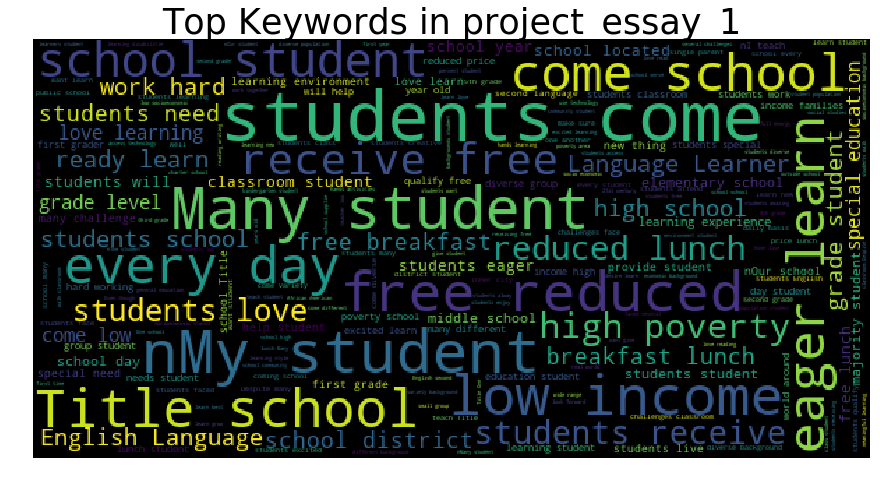

In [55]:
project_essay_2 = train.dropna(subset=['project_essay_2'])
# converting into lowercase
train['project_essay_2'] = train['project_essay_2'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['project_essay_2'] = train['project_essay_2'].map(text_preprocess)


from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(project_essay_1['project_essay_1'].values))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Top Keywords in project_essay_1", fontsize=35)
plt.axis("off")
plt.show()

## 4.20 Gender Analysis

In [56]:
# Creating the gender column
gender_mapping = {"Mrs.": "Female", "Ms.":"Female", "Mr.":"Male", "Teacher":"Unknown", "Dr.":"Unknown", np.nan:"Unknown"  }
train["gender"] = train.teacher_prefix.map(gender_mapping)
test["gender"] = test.teacher_prefix.map(gender_mapping)
train_resource["gender"] = train_resource.teacher_prefix.map(gender_mapping)
test_resource["gender"] = test_resource.teacher_prefix.map(gender_mapping)

In [57]:
gender = train["gender"].value_counts()
trace = go.Bar(
    x = gender.index,
    y = (gender / gender.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Gender in terms of projects proposals submitted in % ",
    xaxis=dict(
        title='Gender',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of project proposals submitted in % ',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Female have more count which is approx. 88 % than Male which has 10 % in terms of projects proposals submissions.